In [27]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_squared_error, f1_score
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, BaggingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier, RandomForestClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.svm import SVR, SVC


import pandas as pd
import codecs
import time
import datetime
import re
from datetime import datetime 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import seaborn as sns
from bokeh.plotting import figure, output_file, show
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
%config InlineBackend.figure_format = 'retina'

In [28]:
df = pd.read_csv('../Cal_Fire/df_acres', low_memory=False, index_col=False)

In [29]:
df.set_index('start_date', inplace=True)

In [31]:
to_drop = ['fire_department_name', 'incident_name',
                  'county', 'street_address',
                  'city', 'state', 'zip',
                  'burn_duration', 'cause', 'incident_number',
                 'type_descriptions', 'cross_streets_or_directions_or_national_grid',
                 'containment_date']

In [33]:
X = df.drop(columns=to_drop)
y = df['burn_duration']

In [34]:
df = df.loc[df['burn_duration']> .000 ]

In [37]:
df = df.loc[df['latitude']> 31 ]
df = df.loc[df['latitude']< 44 ]
df = df.loc[df['longitude']< -111 ]
df = df.loc[df['longitude']> -125]

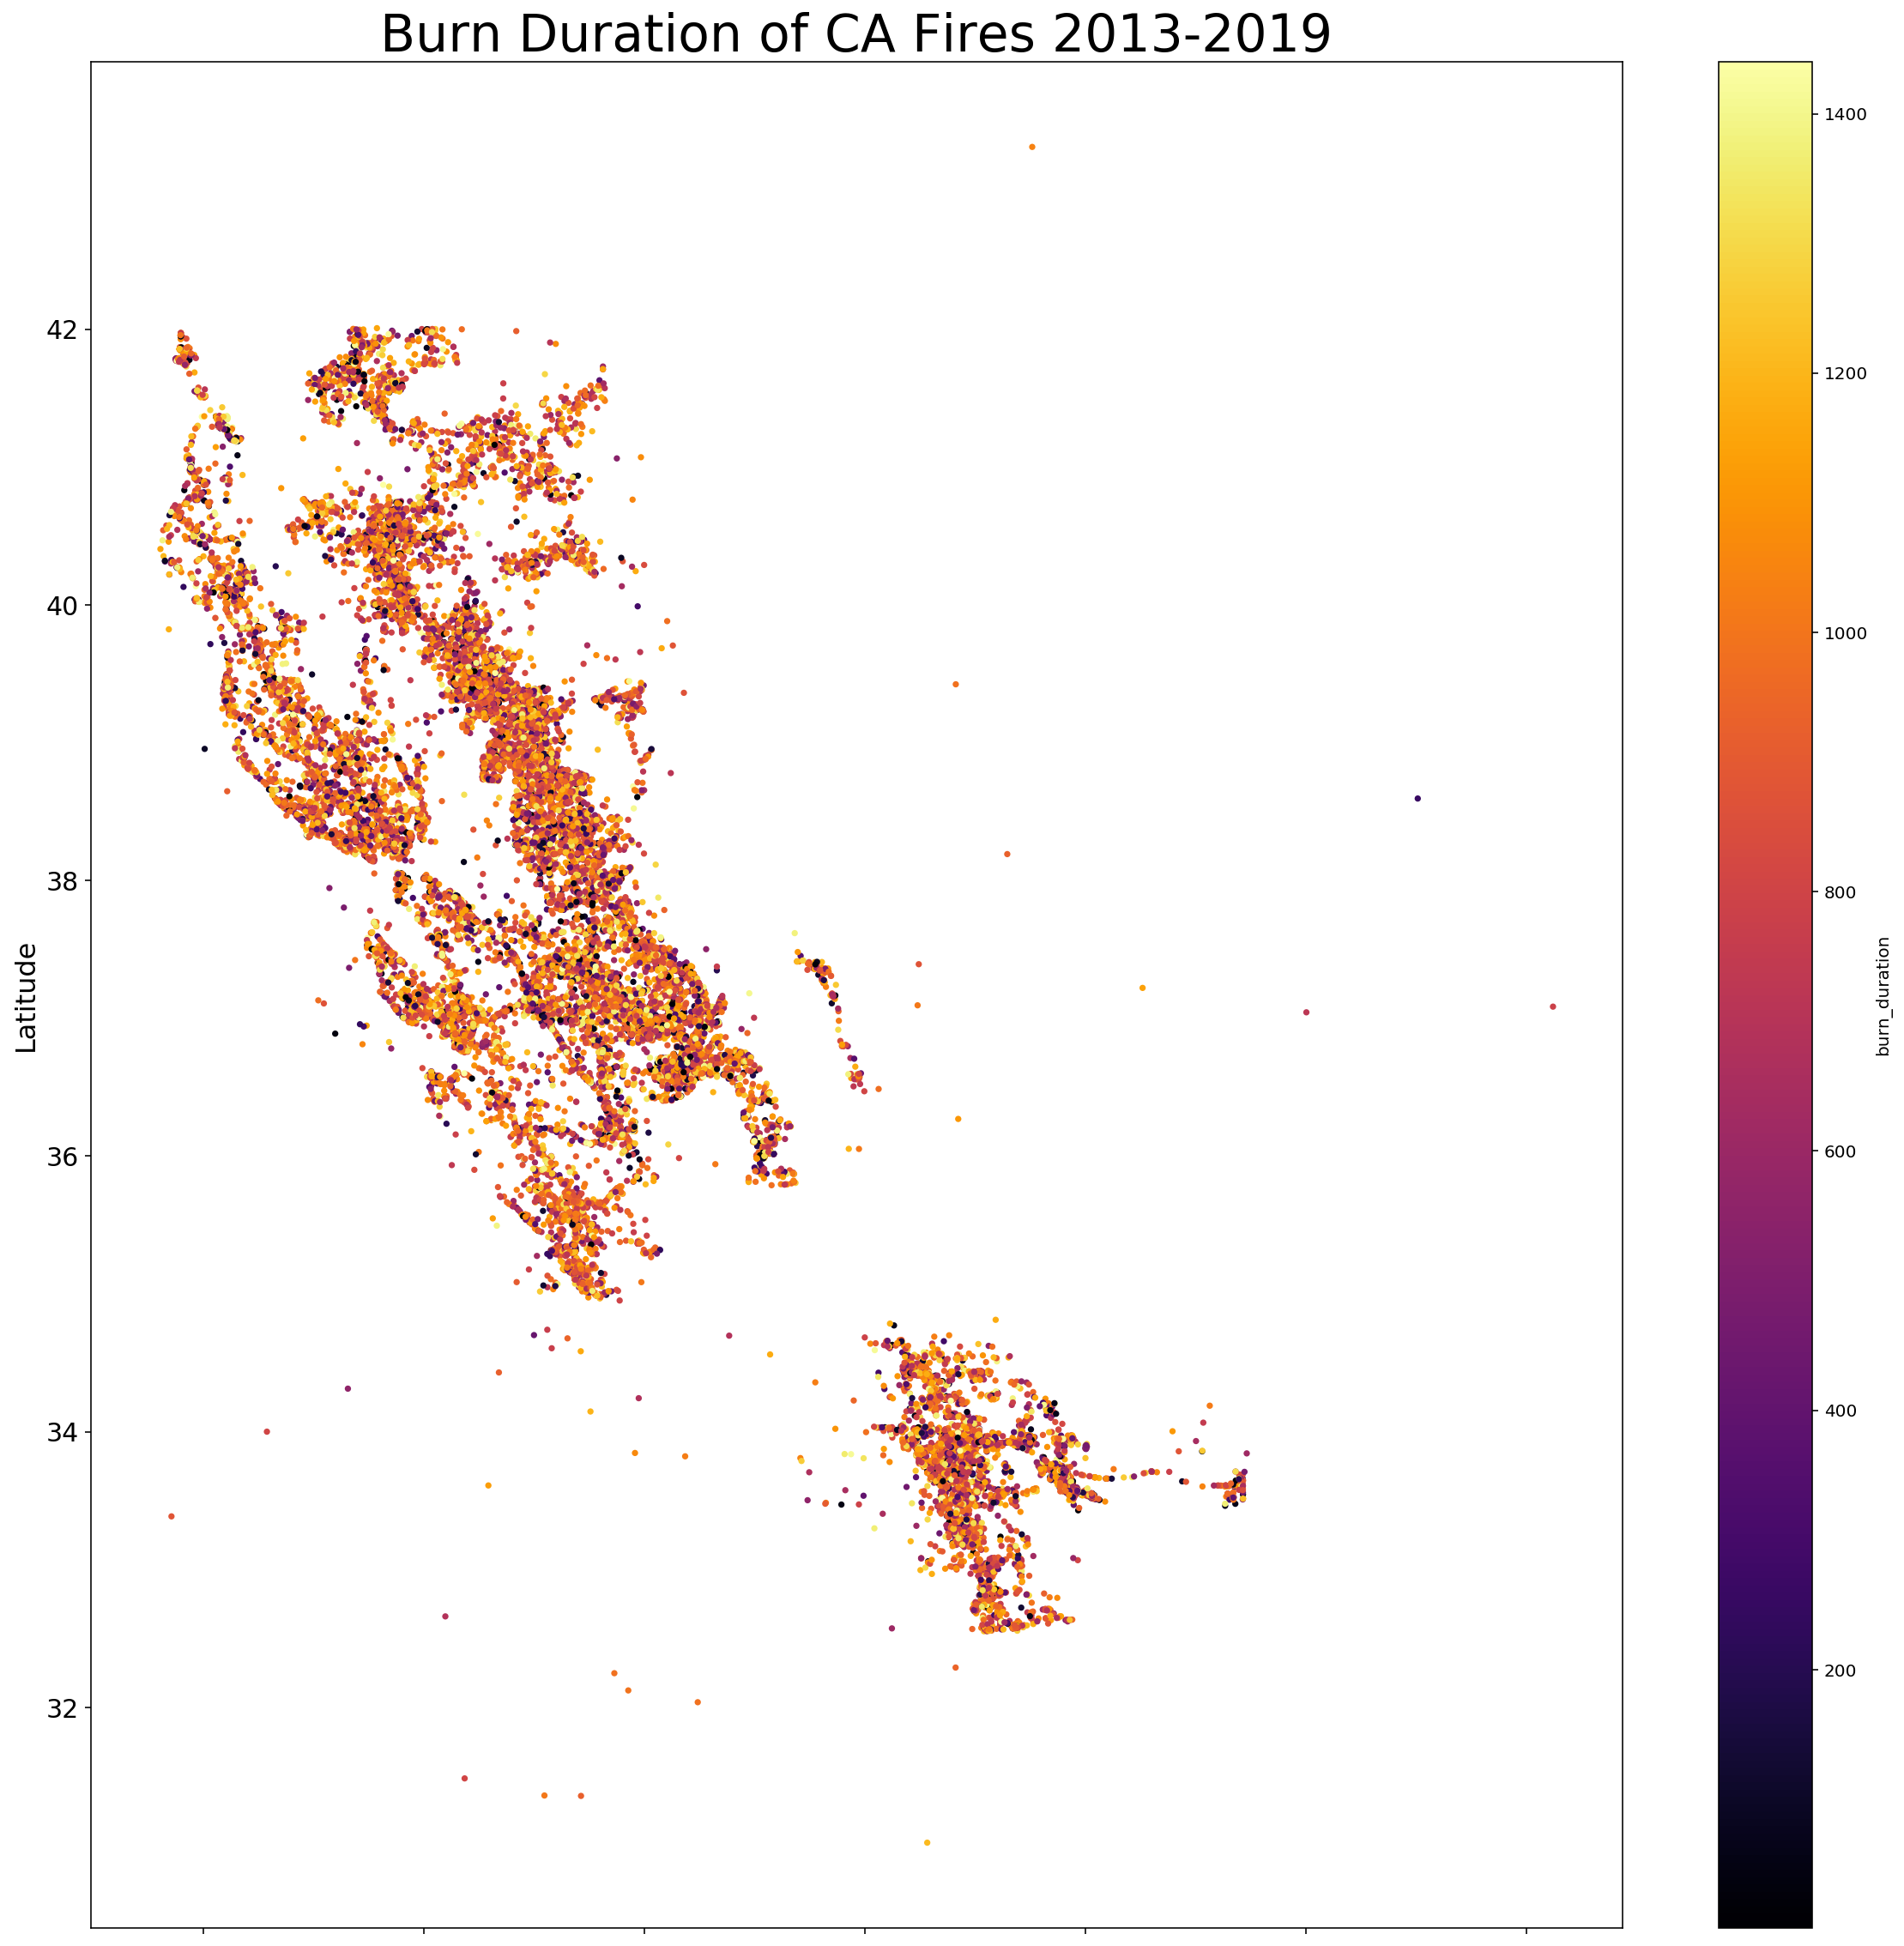

In [39]:
t = 'Burn Duration of CA Fires 2013-2019'

df.plot(kind="scatter",
        x="longitude", use_index= True,fontsize = 15,
        y="latitude",
        c="burn_duration", 
         cmap="inferno",
        
        legend = False,
        figsize=(20, 20), s=7);
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize = 16)
# plt.clabel('Burn Time in Minutes')
plt.title(t, fontsize=30);
plt.savefig('../Cal_Fire/burn_duration_graph', dpi=300)
# plt.xticks(list(range(df['longitude'])), df['longitude'].index, fontsize=12)

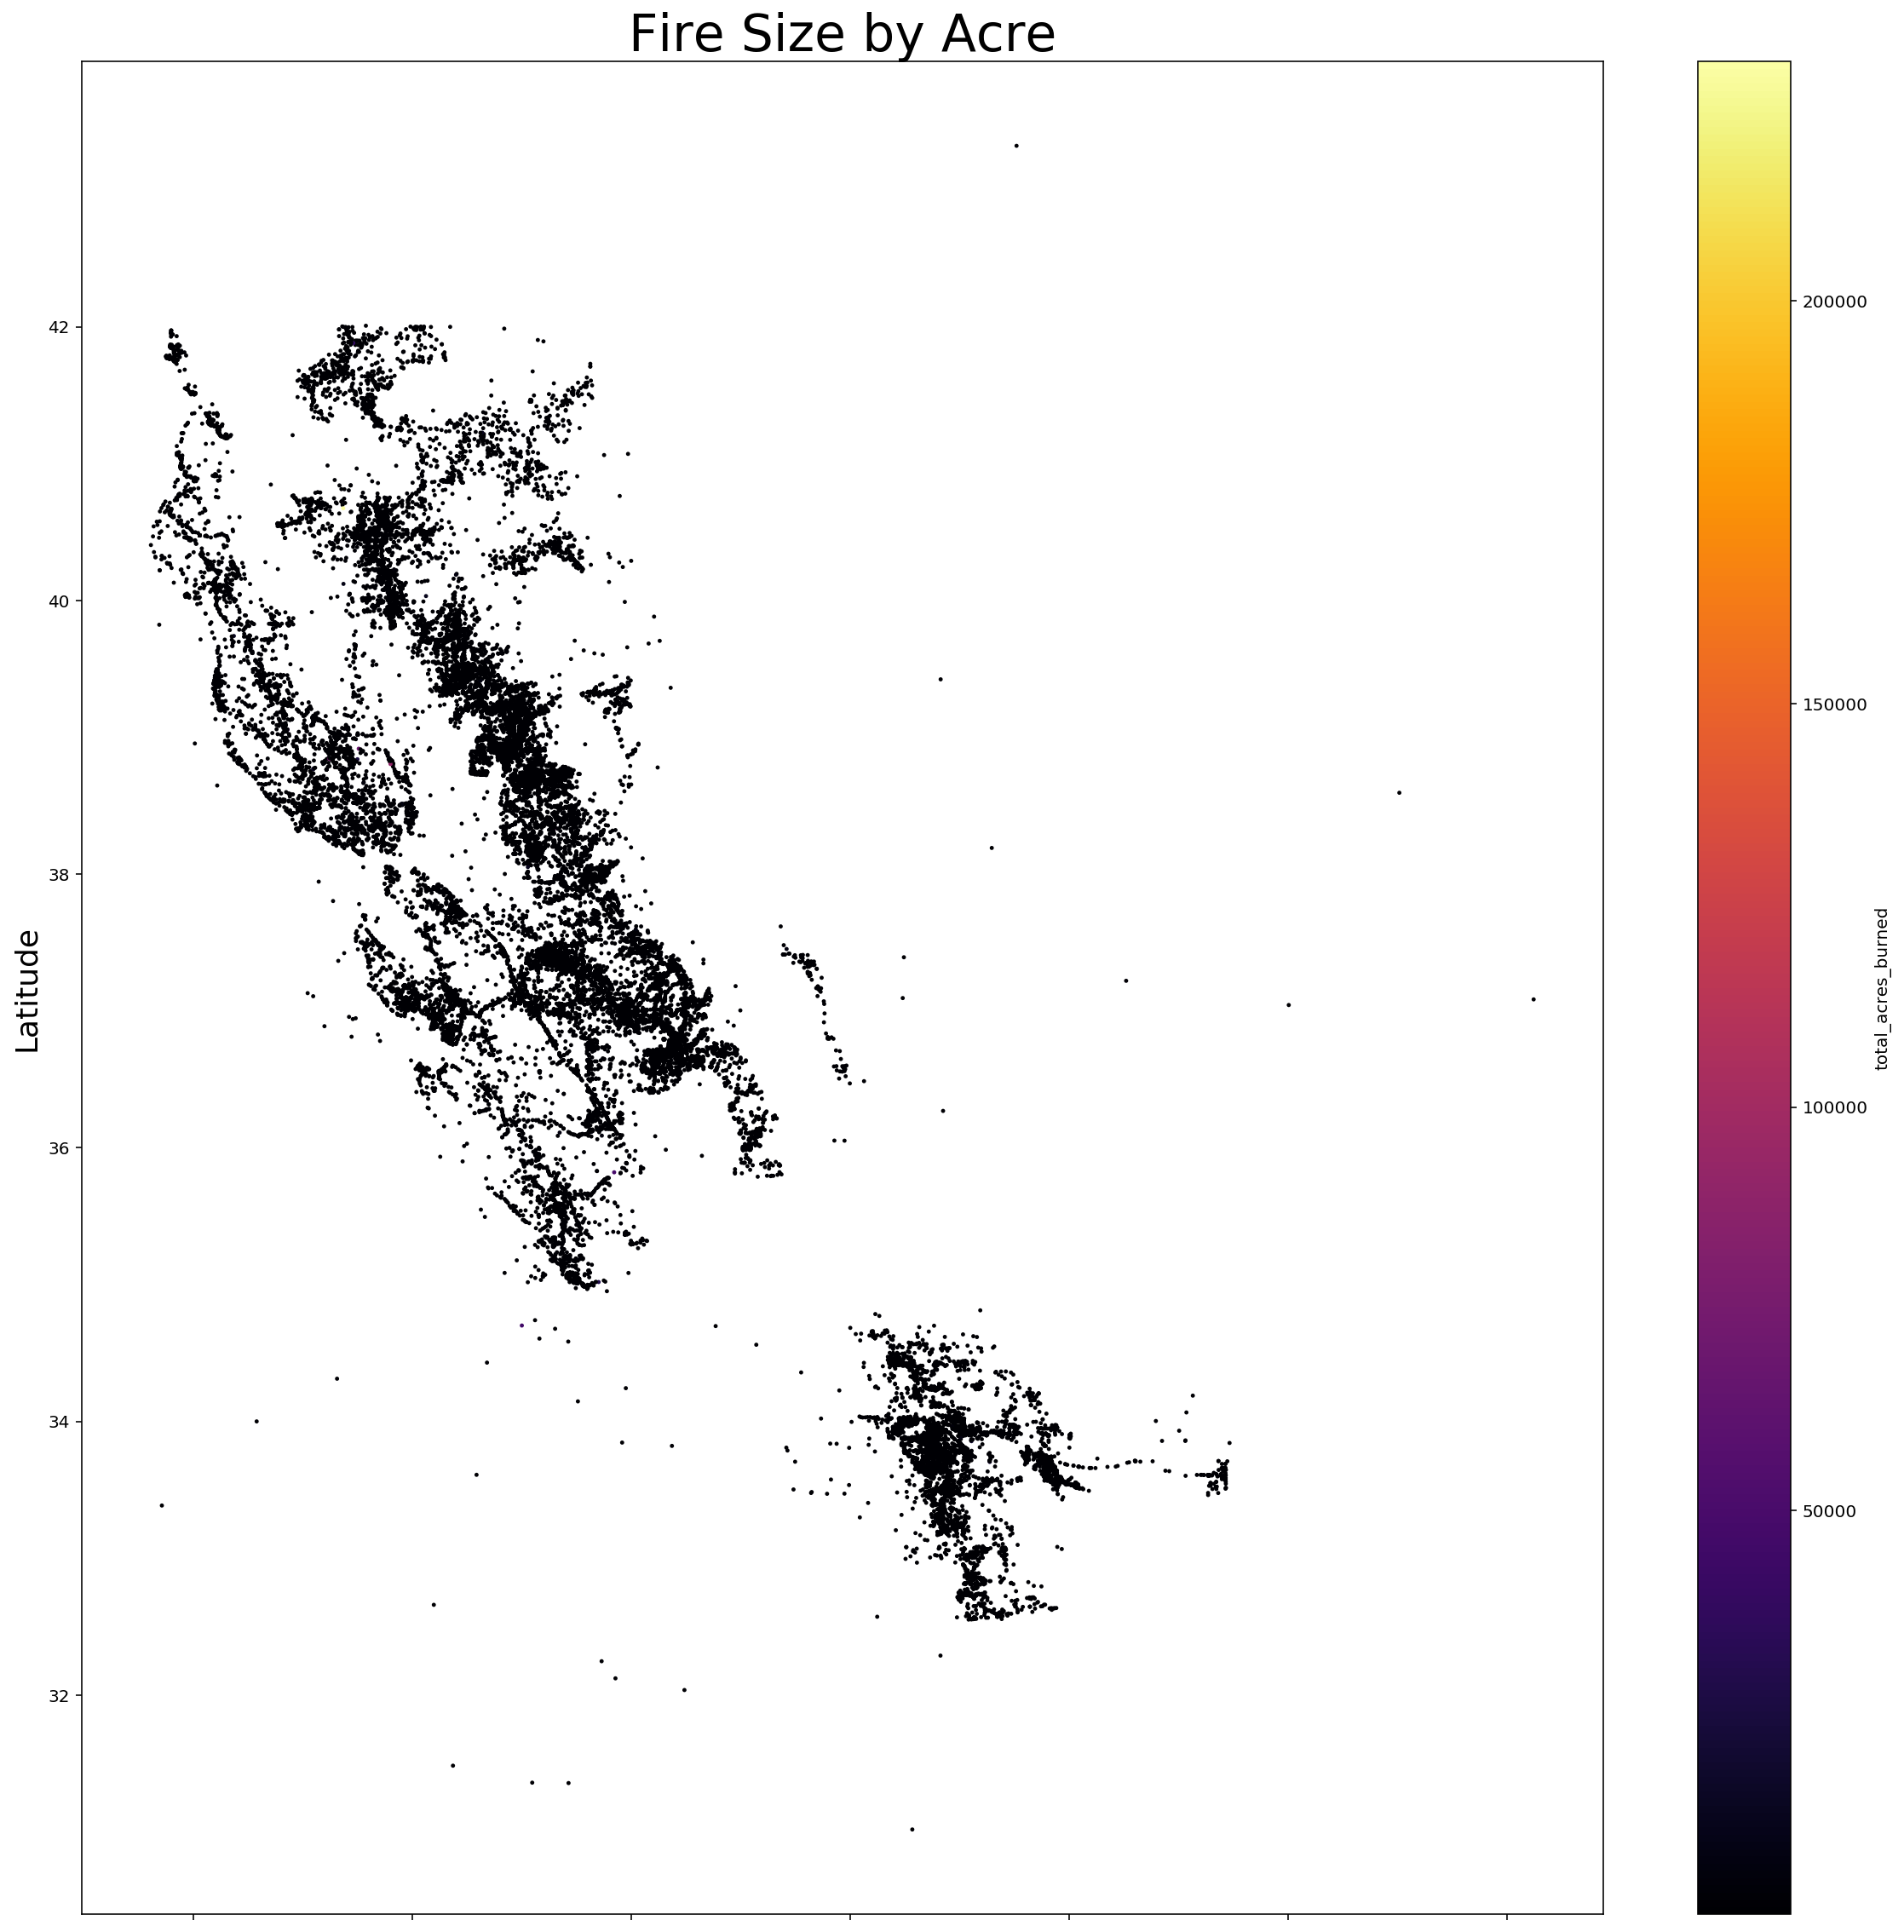

In [71]:
df.plot(kind="scatter", x="longitude", y="latitude", c="total_acres_burned",
         cmap="inferno",  figsize=(20, 20), s=2)
plt.ylabel('Latitude', fontsize = 18)
plt.title("Fire Size by Acre", fontsize=30)
plt.savefig('../Cal_Fire/burn_acres', dpi = 300);

In [60]:
df_small = df[df['total_acres_burned']<.3]

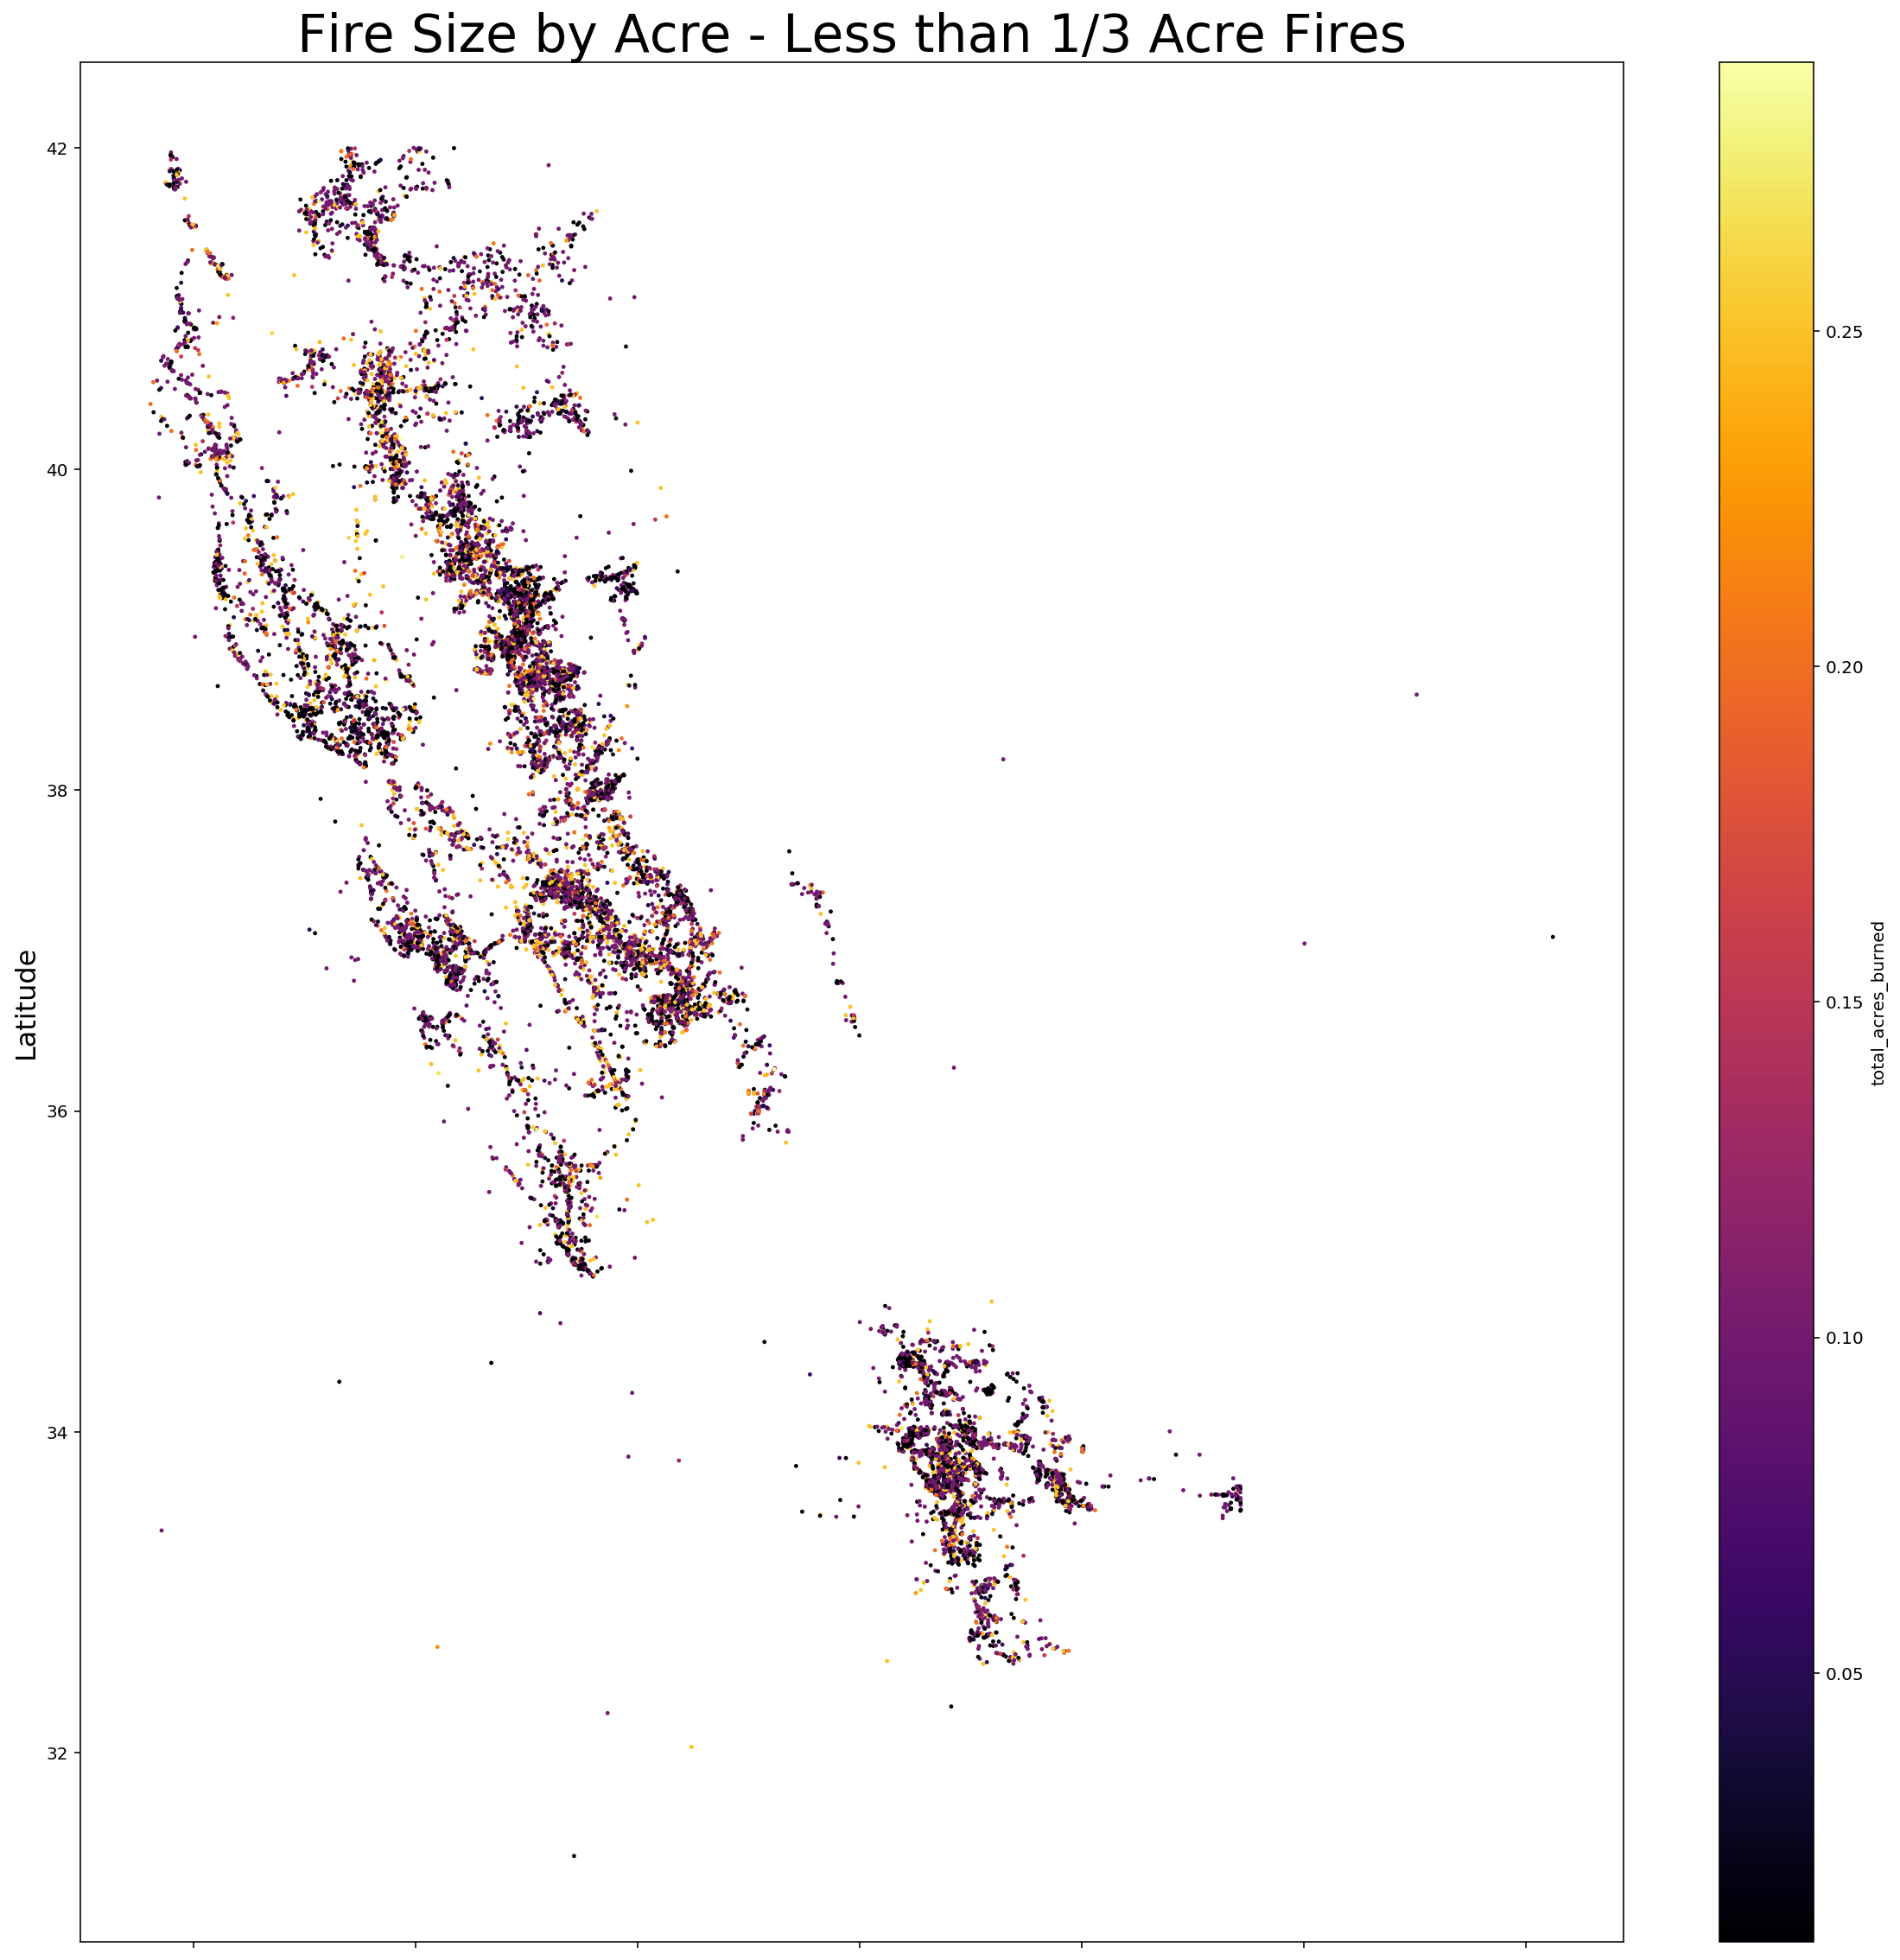

In [64]:
df_small.plot(kind="scatter", x="longitude", y="latitude", c="total_acres_burned",
         cmap="inferno",  figsize=(20, 20), s=2)
plt.ylabel('Latitude', fontsize = 16)
plt.title("Fire Size by Acre - Less than 1/3 Acre Fires", fontsize=30)
plt.savefig('../Cal_Fire/burn_acres_small', dpi = 300);

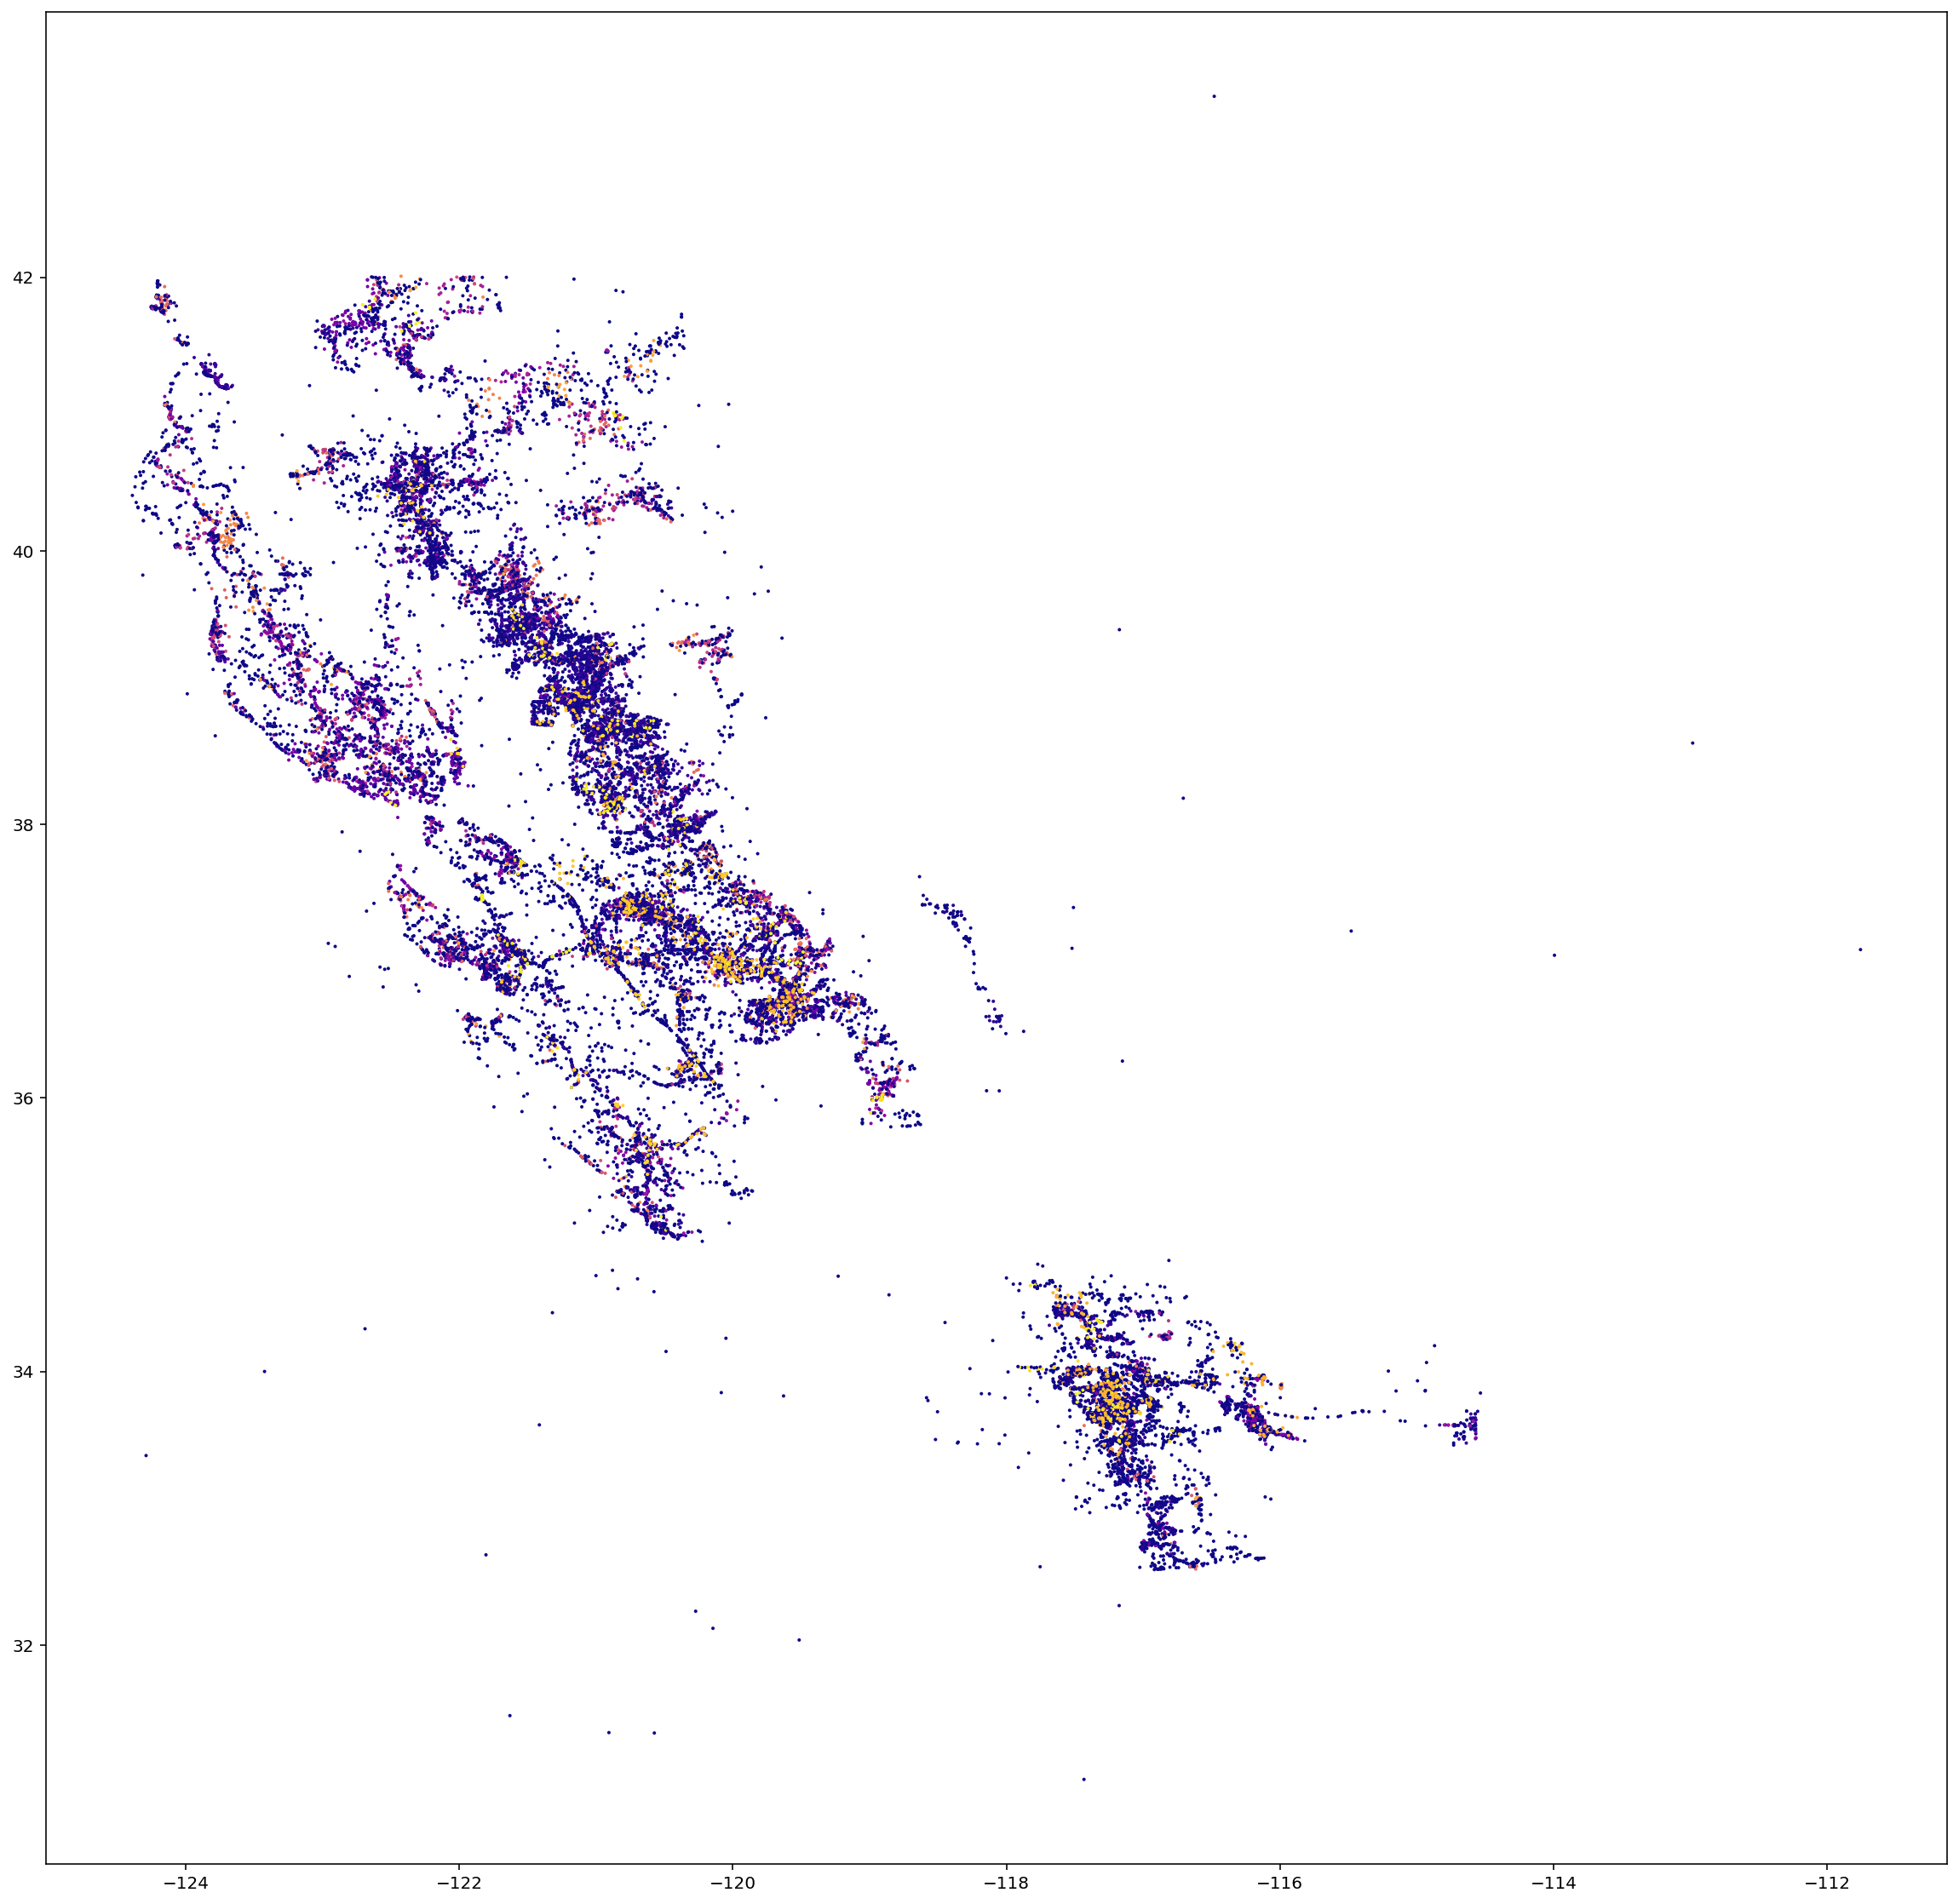

In [655]:
plt.figure(figsize=(20, 20))
plt.scatter(df['longitude'], df['latitude'], c=db_model.labels_, s=1, cmap="plasma");

In [43]:
df.type_descriptions.value_counts()

    Grass fire, includes fire confined to area    14794
    Brush, or brush and grass mixture fire         7183
    Natural vegetation fire, other                 4447
    Forest, woods, or wildland fire                4109
    Unauthorized burning                            760
    Cultivated trees or nursery stock fire          131
    Cultivated vegetation, crop fire, other         127
    Cultivated grain or crop fire                   119
    Cultivated orchard or vineyard fire             107
Name: type_descriptions, dtype: int64

In [45]:
string_columns = ['fire_department_name', 'incident_name','incident_number',
                  'county', 'street_address',
                  'city', 'state', 'zip',
                  'burn_duration', 'cause', 'incident_number',
                 'type_descriptions', 'cross_streets_or_directions_or_national_grid',
                 'containment_date']

# TRAIN TEST SPLIT

In [72]:
X = df.drop(columns= string_columns)
y = np.log(df.burn_duration)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.5
)

In [73]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [74]:
pca = PCA(random_state=42)

In [75]:
Z_train = pca.fit_transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

In [76]:
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 20 components): {np.round(var_exp[:20], 3)}')

print('')

# Generate the cumulative explained variance.
cum_var_exp =np.cumsum(var_exp)
print(f'Cumulative explained variance (first 20 components): {np.round(cum_var_exp[:20], 3)}')

Explained variance (first 20 components): [0.016 0.012 0.011 0.011 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01 ]

Cumulative explained variance (first 20 components): [0.016 0.028 0.039 0.049 0.06  0.07  0.081 0.091 0.101 0.111 0.122 0.132
 0.142 0.152 0.162 0.173 0.183 0.193 0.203 0.213]


In [ ]:
plt.figure(figsize=(20,20))

plt.plot(range(len(var_exp)), var_exp, lw=3, label = 'Explained Variance')

plt.plot(range(len(var_exp)), cum_var_exp, lw=3, color = 'orange', label = 'Cumulative Variance Explained')

plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')


plt.xlim([-1,21])
plt.ylim([-0.01,1.01])


plt.ylabel('Variance Explained', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)


plt.xticks(range(0, 200, 5), range(1, 200, 5), fontsize=12)
plt.yticks(fontsize=18)
    
plt.title('Component vs. Variance Explained For Wildfire Prediction', fontsize=24)
plt.legend(fontsize=18)
plt.savefig('../Cal_Fire/PCA', dpi=300);

In [78]:
pca = PCA(n_components=146)

# Fit PCA to training data.
pca.fit(X_train)
Z_train = pca.fit_transform(X_train)
Z_test = pca.transform(X_test)

In [87]:
rf = RandomForestRegressor()

rf.fit(Z_train, y_train)

# Score on training and testing sets.
print(f'Training Score: {round(rf.score(Z_train, y_train),4)}')
print(f'Testing Score: {round(rf.score(Z_test, y_test),4)}')

Training Score: 0.8369
Testing Score: -0.1315


In [84]:
lm = LinearRegression()
lm.fit(Z_train, y_train)

# Score on training and testing sets.
print(f'Training Score: {round(lm.score(Z_train, y_train),4)}')
print(f'Testing Score: {round(lm.score(Z_test, y_test),4)}')

Training Score: 0.0149
Testing Score: -0.0043


In [88]:
knr = KNeighborsRegressor()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)
knr.fit(X_train_sc, y_train)
print(f'Score on training set: {knr.score(X_train_sc, y_train)}')
print(f'Score on training set: {knr.score(X_test_sc, y_test)}')

Score on training set: 0.20666570741164714
Score on training set: -0.17155514603747402


In [93]:
# abr = AdaBoostRegressor()
# abr.fit(X_train, y_train)
# print(f'Score on training set: {abr.score(Z_train, y_train)}')
# print(f'Score on testing set: {abr.score(Z_test, y_test)}')

In [94]:
# svr = SVR()
# svr.fit(X_train, y_train)
# print(f'Score on training set: {svr.score(Z_train, y_train)}')
# print(f'Score on testing set: {svr.score(Z_test, y_test)}')

In [ ]:
geo = pd.get_dummies(df[['longitude', 'latitude', "type_descriptions", 'cause']])
geo.head()

In [ ]:
df.shape

In [654]:
db_model = DBSCAN(eps = .1, min_samples=5)
db_model.fit(geo)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [545]:
X['cluster'] = db_model.labels_
X = pd.get_dummies(columns=['cluster'], data=X, drop_first=True)

In [547]:
X_train, X_test, y_train, y_test = train_test_split(
    X.copy(), y.copy(), random_state=42, test_size=0.5, shuffle = False
)

In [550]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [551]:
print(model20.score(X_train, y_train))
print(model20.score(X_test, y_test))

0.8441822241747107
-0.10648736739134734


In [741]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [742]:
print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

0.21279838810913387
-0.17550720308103981
